# Crop image, while preserving header

In [49]:
%matplotlib notebook
import matplotlib
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from matplotlib.colors import LogNorm
from shapely.geometry import Polygon
from descartes import PolygonPatch
from astropy.nddata import Cutout2D

#Declare variables
pixel_center_x,pixel_center_y,box_width_x,box_width_y=2780,538,500,300

#The name of the file to be cropped
input_filename="oph_hs_s.fits"

#What you want to call the cropped file
cropped_filename="oph_hs_s_cropped.fits"

#Read in the data
data=fits.getdata(input_filename)

#Read in the wcs info
wcs=WCS(fits.getheader(input_filename))

#Make the cutout
cutout=Cutout2D(data,(pixel_center_x,pixel_center_y),(box_width_y,box_width_x),wcs=wcs) 

#Write out cropped image with correct WCS info
fits.writeto("oph_hs_s_cropped.fits",cutout.data,header=cutout.wcs.to_header(),clobber=True)

# Now, enter contour level you want to use to define mask; once contour appears on image, click inside contour and run next cell!

<IPython.core.display.Javascript object>


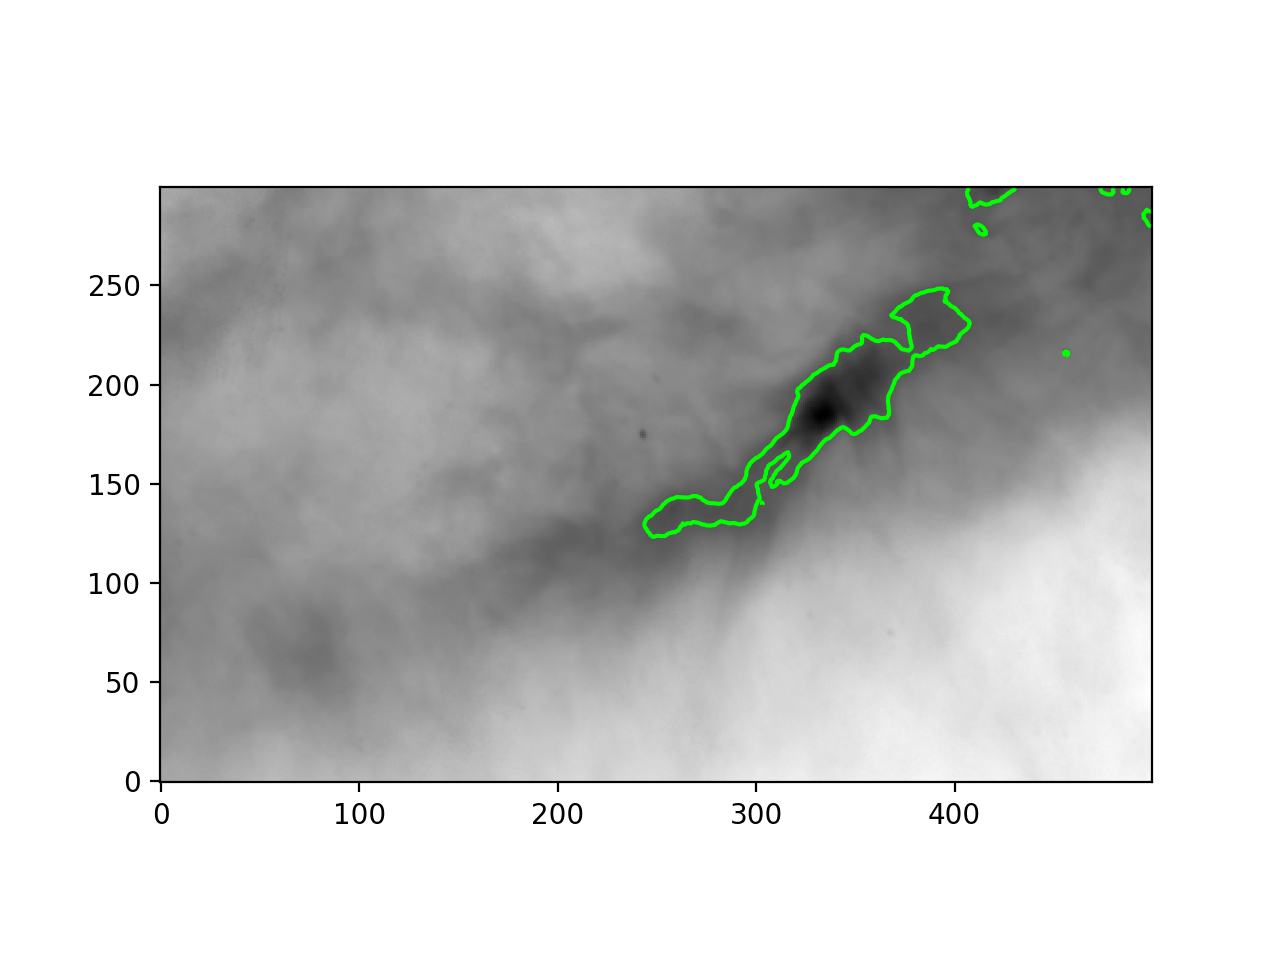

In [50]:
#Set the contour level threshold you want to use to define the filament
contour_level=255

#Set the name of the input file (in our case, the cropped image)
input_filestr="oph_hs_s_cropped.fits"

#Set the name of what you want to call the output file
output_filestr="oph_hs_s_cropped_mask.fits"

infilcoords = []

fig, axes = plt.subplots(1)

#Read in image data
image_data,header=fits.getdata(input_filestr,header=True)

#Show intensity image
axes.imshow(image_data,origin='lower',cmap='Greys',norm=LogNorm())

#Plot contours
c=axes.contour(image_data,levels=[contour_level],colors=['lime'])

def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print('x = %d, y = %d'%(
        ix, iy))
    infilcoords.append((ix, iy))

    if len(coords) == 1:
        fig.canvas.mpl_disconnect(cid)

    return infilcoords

cid = fig.canvas.mpl_connect('button_press_event', onclick)

[4]


<IPython.core.display.Javascript object>


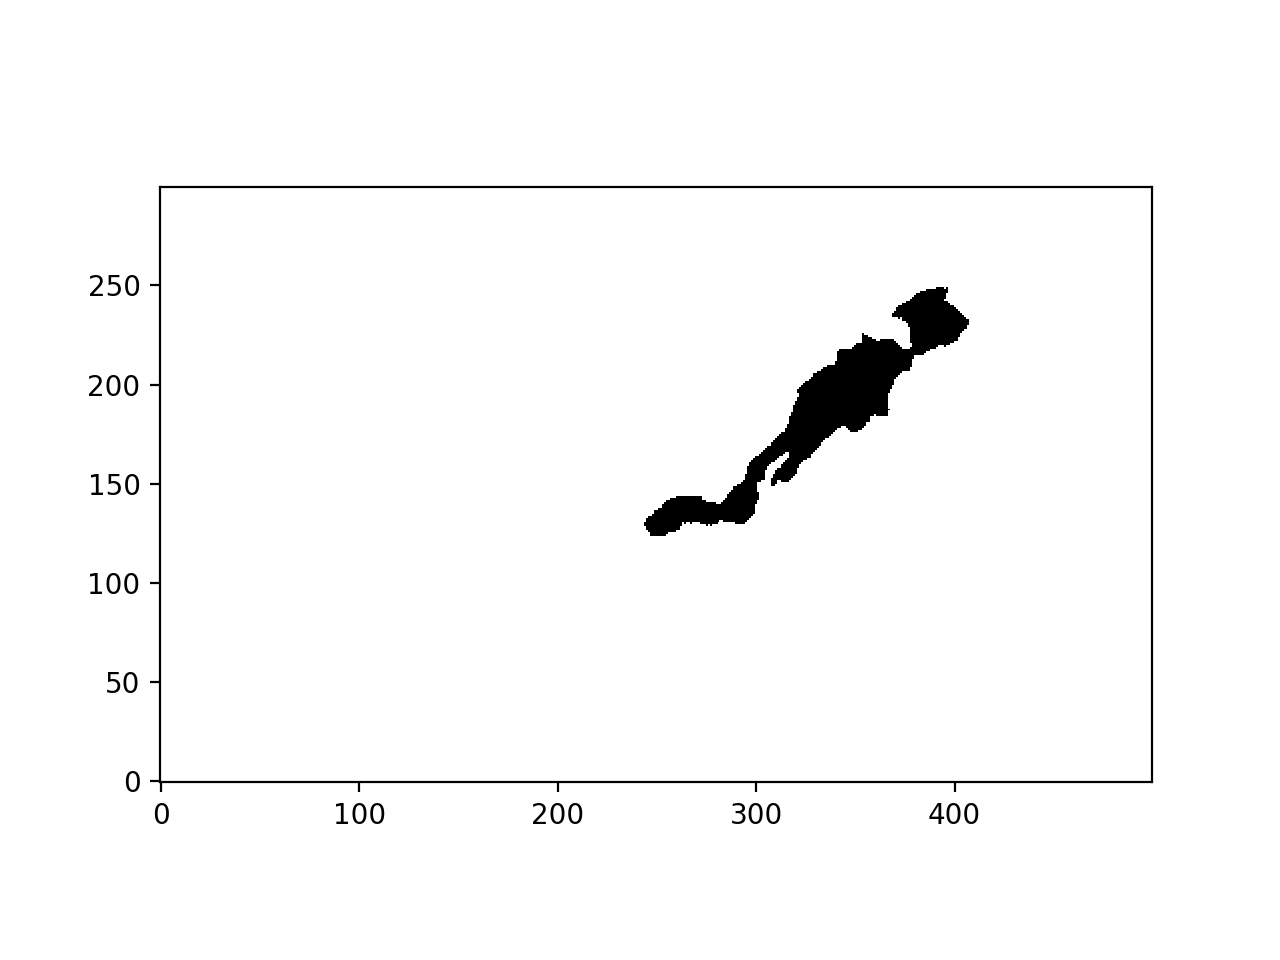

In [48]:
#Convert contours to list of points
p = c.collections[0].get_paths()

#Extract polygon corresponding to chosen contour
points=list(infilcoords)

#Now collect pixels inside it
for (point,filnum) in zip(points,range(0,len(points))):

    index=[]
    for i in range(0,len(p)):
        if p[i].contains_point((point[0],point[1]))==True:
            index.append(i)

    print(index)
    filpoints=np.empty((0,2))
    xpix=[]
    ypix=[]
    for k in range(0,len(index)):              
        x=p[index[k]].vertices[:,0]
        y=p[index[k]].vertices[:,1]

        poly=Polygon([(i[0], i[1]) for i in zip(x,y)])
        xpix.append([i for i in x])
        ypix.append([i for i in y])

        patch=PolygonPatch(poly)

        # calculate the x and y points possibly within the image
        y_int = np.arange(0, image_data.shape[0])
        x_int = np.arange(0, image_data.shape[1])

        # create a list of possible coordinates
        g = np.meshgrid(x_int, y_int)
        coords = list(zip(*(c.flat for c in g)))

        # create the list of valid coordinates inside contours
        filpoints = np.vstack((filpoints,np.vstack([p for p in coords if patch.contains_point(p, radius=0)])))
        
#Make an empty image set points inside mask to 1
empty=np.zeros((image_data.shape))
empty[filpoints[:,1].astype(int),filpoints[:,0].astype(int)]=1

#Display mask
fig=plt.figure()
plt.imshow(empty,origin='lower',cmap='binary')

#Output mask to file
fits.writeto(output_filestr,empty,header,overwrite=True)